In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement

# assign the station class to a variable called `Station`
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()

print(f"('{latest_date}',)")


('2017-08-23',)


In [10]:
print(type(latest_date))

<class 'str'>


In [11]:
# convert latest_date into datetime
latest_date_str = "2017-08-23"


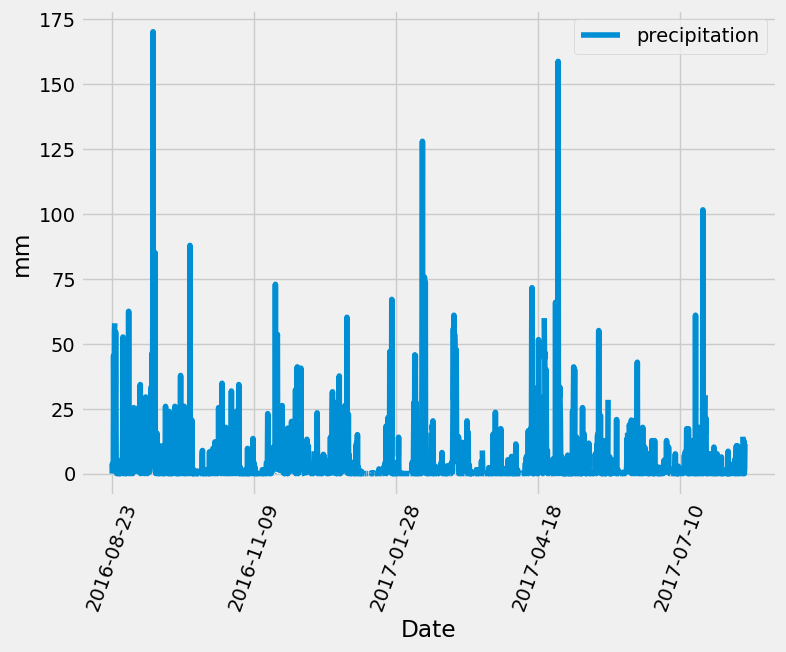

In [12]:
# Design a query to retrieve the last 12 months of precipitation data 
# and plot the results.
# Starting from the most recent data point in the database.
latest_date = dt.datetime.strptime(latest_date_str, "%Y-%m-%d")
# Calculate the date one year from the last date in data set.
last_year = latest_date - dt.timedelta(days=366)
#print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp) \
                           .filter(Measurement.date >= last_year) \
                           .order_by(Measurement.date).all()

# To confirm correct data 
#for data in precipitation_data:
#    print(precipitation_data)

# Save the query results as a Pandas DataFrame with explicit column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.set_index('date', inplace=True)  # Set date as index for plotting

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='line', figsize=(8, 6))
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()



In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df['precipitation'].describe()

# Print the summary statistics
precipitation_stats



count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(func.count(Station.id)).all()
station_count


[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
#    order_by(func.count(Measurement.station).desc()).\
#    group_by(Measurement.station).all() 

#print(active_stations)

active_stations=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station,func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).first()

# Check to see if most active station was selected:
# print(most_active_station) 
# Isolate station number from this list of station numbers and count of stations
most_active_station_number = most_active_station[0]
most_active_station_number

# Lowest temperature for most active station
lowest_temperature = session.query(func.min(Measurement.tobs)).\
  filter(Measurement.station==most_active_station_number).all()
#print(lowest_temperature)

# Highest temperature for most active station
highest_temperature = session.query(func.max(Measurement.tobs)).\
  filter(Measurement.station==most_active_station_number).all()

#print(highest_temperature)

# Avg temperature for most active station
average_temperature = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active_station_number).all()

#print(average_temperature)

temperatures = (lowest_temperature, highest_temperature, average_temperature)
print (temperatures)

([(12.2,)], [(29.4,)], [(22.03582251082252,)])


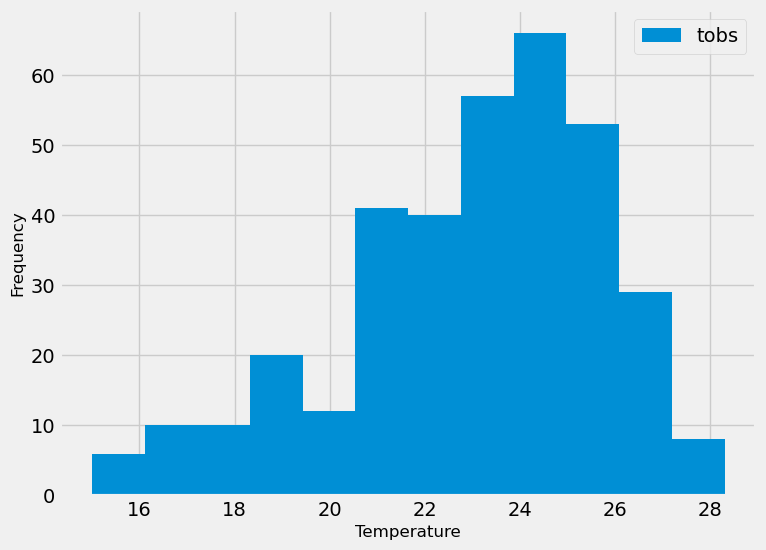

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_number).filter(Measurement.date >= last_year).\
    group_by(Measurement.date).all()

# Put data into dataframe so it can be plotted as histogram
plot_df = pd.DataFrame(data=temp_results, columns=["date", "tobs"])
plot_df = plot_df.set_index('date', drop=True)

#Plot the results as a histogram with bins=12
plt.figure(figsize=(8, 6))
plt.hist(plot_df['tobs'],12, label="tobs")
plt.ylabel("Frequency", fontsize=12)
plt.xlabel('Temperature', fontsize=12)
plt.legend()
plt.show()




# Close Session

In [21]:
# Close Session
session.close()
